In [1]:
# LIBRARIES

# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# arima import
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#lstm, stat import
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load and Basic Info

def load_tesla_data(filepath):

    df = pd.read_csv(filepath, parse_dates=['Date'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    return df

df= load_tesla_data("/content/TSLA.csv")
print("DATA OVERVIEW")
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nLast few rows:")
print(df.tail())
print(f"\nBasic statistics:")
print(df.describe())
print(f"\nMissing values: {df.isnull().sum()}")

DATA OVERVIEW
Data shape: (2416, 6)
Date range: 2010-06-29 00:00:00 to 2020-02-03 00:00:00

First few rows:
                 Open   High        Low      Close  Adj Close    Volume
Date                                                                   
2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900

Last few rows:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2020-01-30  632.419983  650.880005  618.000000  640.809998  640.809998   
20

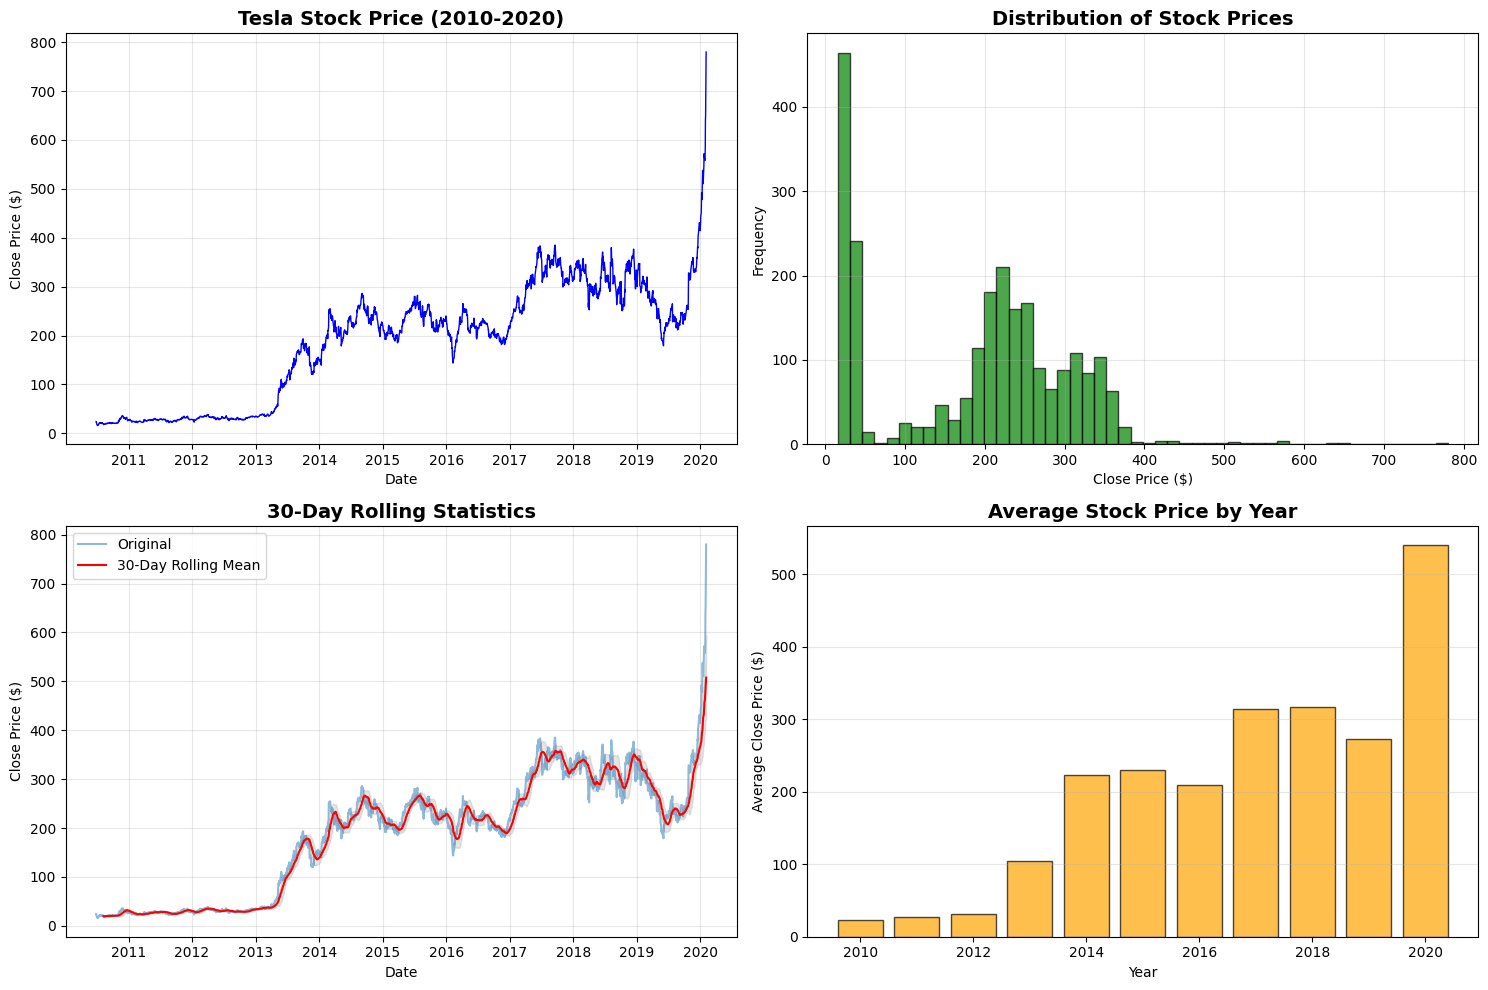

In [3]:
# Data visualization


fig, axes = plt.subplots(2, 2, figsize=(15, 10))


axes[0, 0].plot(df.index, df['Close'], color='blue', linewidth=1)
axes[0, 0].set_title('Tesla Stock Price (2010-2020)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Close Price ($)')
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].hist(df['Close'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Stock Prices', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Close Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)


rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()
axes[1, 0].plot(df.index, df['Close'], label='Original', alpha=0.5)
axes[1, 0].plot(df.index, rolling_mean, label='30-Day Rolling Mean', color='red')
axes[1, 0].fill_between(df.index, rolling_mean - rolling_std, rolling_mean + rolling_std,
                         alpha=0.2, color='gray')
axes[1, 0].set_title('30-Day Rolling Statistics', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Close Price ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


df['Year'] = df.index.year
yearly_data = df.groupby('Year')['Close'].mean()
axes[1, 1].bar(yearly_data.index, yearly_data.values, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Average Stock Price by Year', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Close Price ($)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('tesla_eda.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
# TRAIN-TEST split

train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

print(f"Training data: {len(train_data)}")
print(f"Testing data: {len(test_data)}")

Training data: 1932
Testing data: 484


In [5]:
# ARIMA model

def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("Data is stationary (p-value <= 0.05)")
        return True
    else:
        print("Data is non-stationary (p-value > 0.05)")
        return False

is_stationary = check_stationarity(train_data['Close'])

if not is_stationary:
    arima_order = (5, 1, 0)
else:
    arima_order = (5, 0, 0)


print(f"\nTraining ARIMA model with order {arima_order}...")
arima_model = ARIMA(train_data['Close'], order=arima_order)
arima_fitted = arima_model.fit()


# Rolling window forecast for ARIMA
arima_predictions = []
history = list(train_data['Close'].values)


for t in range(len(test_data)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_data['Close'].iloc[t]
    history.append(obs)
    if (t + 1) % 50 == 0:
        print(f"Processed {t + 1}/{len(test_data)} predictions")

arima_predictions = np.array(arima_predictions)

# rmse, mae, mape
arima_rmse = np.sqrt(mean_squared_error(test_data['Close'], arima_predictions))
arima_mae = mean_absolute_error(test_data['Close'], arima_predictions)
arima_mape = mean_absolute_percentage_error(test_data['Close'], arima_predictions) * 100


print("ARIMA Performance Metrics:")
print(f"RMSE: ${arima_rmse:.2f}")
print(f"MAE: ${arima_mae:.2f}")
print(f"MAPE: {arima_mape:.2f}%")


Checking stationarity of training data:
ADF Statistic: -0.764556
p-value: 0.829312
Data is non-stationary (p-value > 0.05)

Training ARIMA model with order (5, 1, 0)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Performing rolling window forecast...
Processed 50/484 predictions
Processed 100/484 predictions
Processed 150/484 predictions
Processed 200/484 predictions
Processed 250/484 predictions
Processed 300/484 predictions
Processed 350/484 predictions
Processed 400/484 predictions
Processed 450/484 predictions
ARIMA Performance Metrics:
RMSE: $12.43
MAE: $7.68
MAPE: 2.47%



LSTM data shapes:
X_train shape: (1884, 60, 1)
X_test shape: (472, 60, 1)

Building LSTM model...

Training LSTM model (this may take a few minutes)...
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0093 - val_loss: 4.4163e-04
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1340e-04 - val_loss: 4.4856e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6552e-04 - val_loss: 4.6117e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1928e-04 - val_loss: 4.2283e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.1497e-04 - val_loss: 4.4112e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.7149e-04 - val_loss: 4.7829e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5584e-04 - val_loss: 4.5226e-04
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1197e-04 - val_loss: 3.8965e-04
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3704e-04 - val_loss: 3.8531e-04
Epoch 10/50
53

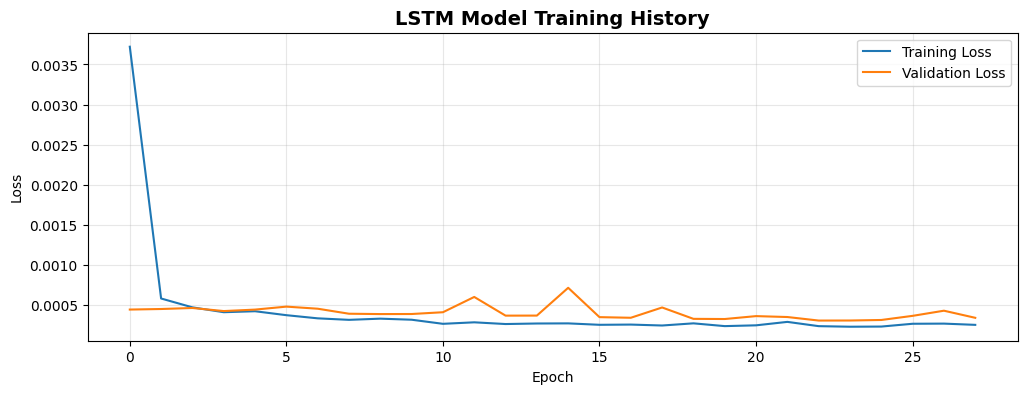

In [6]:
# LSTM model


# Prepare data for LSTM

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)


train_size_lstm = int(len(X) * 0.8)
X_train, X_test = X[:train_size_lstm], X[train_size_lstm:]
y_train, y_test = y[:train_size_lstm], y[train_size_lstm:]

# [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')


# Train LSTM
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)


test_dates = df.index[train_size_lstm + seq_length:]
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_predictions) * 100


print("LSTM Performance Metrics:")
print(f"RMSE: ${lstm_rmse:.2f}")
print(f"MAE: ${lstm_mae:.2f}")
print(f"MAPE: {lstm_mape:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()


 Model      RMSE       MAE  MAPE (%)
ARIMA 12.428604  7.677992  2.471197
 LSTM 21.141804 14.264692  4.507727


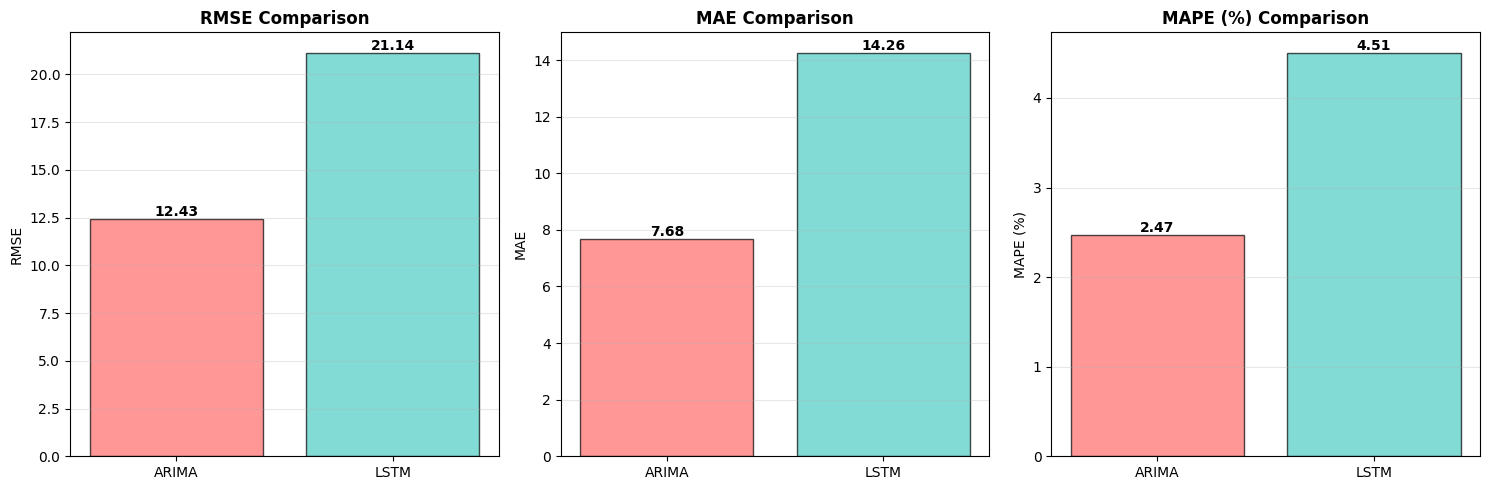

In [7]:
# COMPARE ALL MODELS


comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'RMSE': [arima_rmse, lstm_rmse],
    'MAE': [arima_mae, lstm_mae],
    'MAPE (%)': [arima_mape, lstm_mape]
})

comparison_df = comparison_df.sort_values('RMSE')
print("\n", comparison_df.to_string(index=False))

# Visualizing comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE', 'MAE', 'MAPE (%)']
for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, alpha=0.3, axis='y')


    for i, v in enumerate(comparison_df[metric]):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

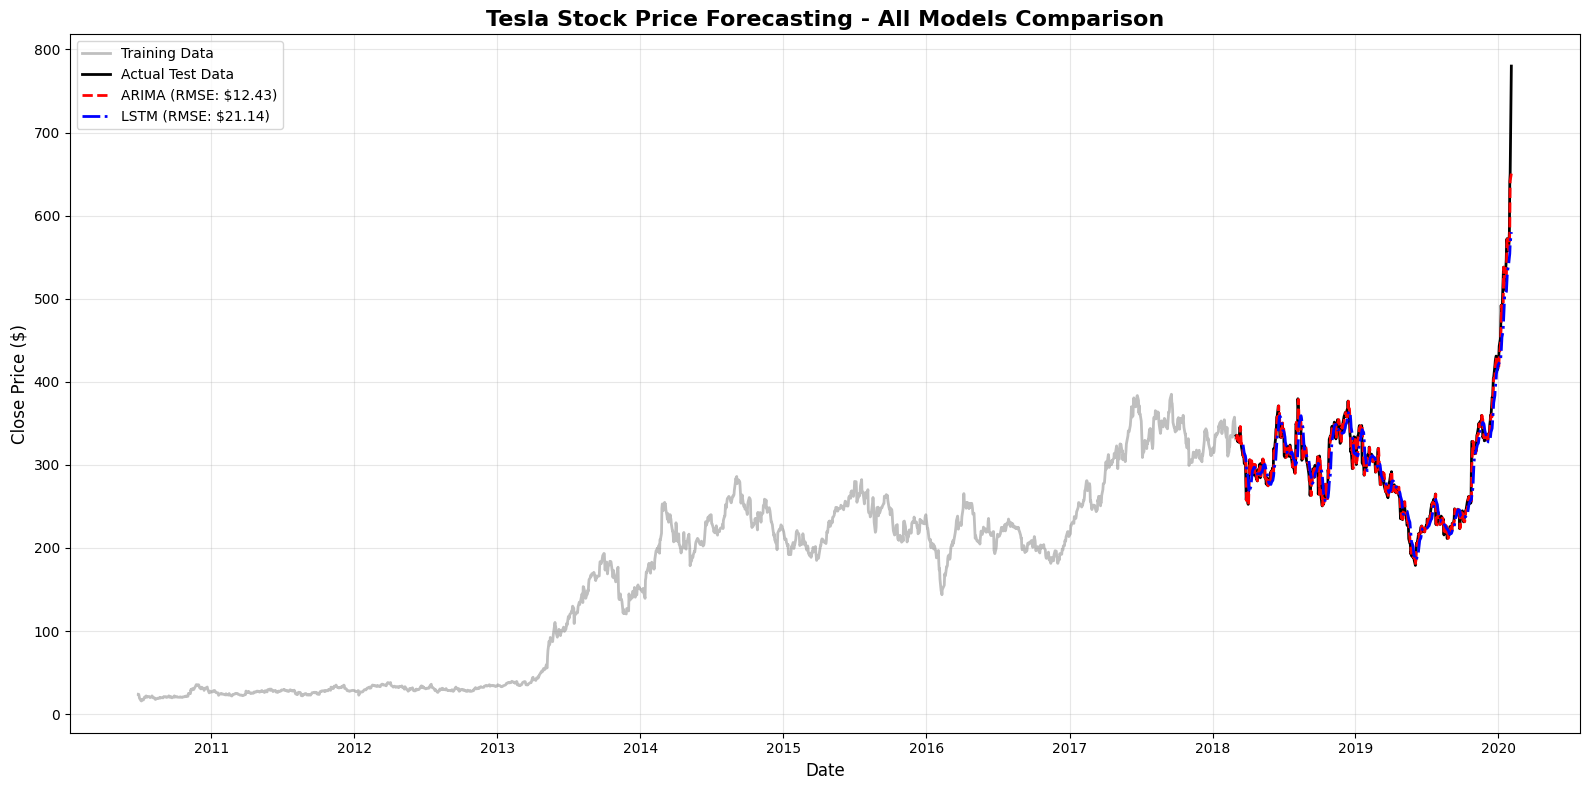

In [8]:
# VISUALIZE PREDICTIONS

plt.figure(figsize=(16, 8))

# training data
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='gray', alpha=0.5, linewidth=2)

# actual test data
plt.plot(test_data.index, test_data['Close'], label='Actual Test Data', color='black', linewidth=2)

# ARIMA predictions
plt.plot(test_data.index, arima_predictions, label=f'ARIMA (RMSE: ${arima_rmse:.2f})', color='red', linestyle='--', linewidth=2)

# LSTM predictions
plt.plot(test_dates, lstm_predictions, label=f'LSTM (RMSE: ${lstm_rmse:.2f})', color='blue', linestyle='-.', linewidth=2)


plt.title('Tesla Stock Price Forecasting - All Models Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price ($)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('all_models_predictions.png', dpi=300, bbox_inches='tight')
plt.show()